In [1]:
# 1. Import required modules/libraries
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from segmentation_models.metrics import IOUScore

2024-12-16 07:12:58.677538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 07:12:58.685706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 07:12:58.695056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 07:12:58.697850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 07:12:58.705490: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


In [2]:
# 2. Define Metrics
# Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)  # Convert logits to binary
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_binary), tf.float32))

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

# Initialize Precision and Recall as Keras metrics globally
precision_metric = Precision()
recall_metric = Recall()

def f1_score(y_true, y_pred):
    precision_value = precision_metric(y_true, y_pred)
    recall_value = recall_metric(y_true, y_pred)
    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())
    return f1

I0000 00:00:1734322379.640258    7815 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734322379.672216    7815 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734322379.672250    7815 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734322379.676367    7815 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734322379.676414    7815 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [3]:
# 3. Function to load images and labels
def load_images_and_labels(image_dir, label_dir, image_size=(288, 288)):
    images = []
    labels = []
    
    for image_name in sorted(os.listdir(image_dir)):
        # Load image and label
        img_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name)
        
        image = img_to_array(load_img(img_path, target_size=image_size, color_mode='grayscale')) / 255.0
        label = img_to_array(load_img(label_path, target_size=image_size, color_mode='grayscale')) / 255.0
        
        images.append(image)
        labels.append(label)
        
    return np.array(images), np.array(labels)

In [4]:
# 4. Load datasets
train_images_dir = "data/train/image/"
train_labels_dir = "data/train/label/"

val_images_dir = "data/val/image/"
val_labels_dir = "data/val/label/"

test_images_dir = "data/test/image/"
test_labels_dir = "data/test/label/"

final_test_images_dir = "data/final_test/image/"
final_test_labels_dir = "data/final_test/label/"

train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir)
val_images, val_labels = load_images_and_labels(val_images_dir, val_labels_dir)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir)

In [5]:
# 5. Define U-Net model
def unet_model(input_size=(288, 288, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # bridge
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    c5 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    c6 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    c7 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='relu')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize model
model = unet_model()

In [6]:
# 6. Compile the model
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(),  
    metrics=[
        IOUScore(name='iou_score'), 
        pixel_accuracy, 
        dice_coefficient, 
        precision_metric, 
        recall_metric, 
        f1_score  
    ]
)

In [7]:
# 7. Print model summary
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 288,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 288, 288,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 288, 288,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 144, 144,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 144, 144,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 144, 144,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 72, 72,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 36, 36,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 36, 36,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 36, 36,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 72, 72,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72, 72,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 72, 72,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 72, 72,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 144, 144,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8. Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=16,
    epochs=50
)

Epoch 1/50


/home/skye/tf/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1734322390.799342    7959 service.cc:146] XLA service 0x7f24c0020eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734322390.799978    7959 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-16 07:13:10.881429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-16 07:13:11.138365: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-16 07:13:22.224594: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,384,144,144]{3,2,1,0}, u8[0]{0}) custom-c

39/42 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coefficient: 0.2370 - f1_score: 0.1121 - iou_score: 0.1365 - loss: 0.2232 - pixel_accuracy: 0.8122 - precision: 0.9480 - recall: 0.0773

2024-12-16 07:13:50.272535: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-16 07:13:51.398512: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - dice_coefficient: 0.2380 - f1_score: 0.1134 - iou_score: 0.1371 - loss: 0.2225 - pixel_accuracy: 0.8123 - precision: 0.9487 - recall: 0.0775

2024-12-16 07:14:01.415091: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-16 07:14:02.543460: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 27.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-16 07:14:08.747508: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-16 07:14:09.396727: W external/local_tsl/tsl/framework/b

42/42 ━━━━━━━━━━━━━━━━━━━━ 62s 922ms/step - dice_coefficient: 0.2383 - f1_score: 0.1138 - iou_score: 0.1373 - loss: 0.2223 - pixel_accuracy: 0.8123 - precision: 0.9489 - recall: 0.0775 - val_dice_coefficient: 0.2817 - val_f1_score: 0.2151 - val_iou_score: 0.1666 - val_loss: 0.2110 - val_pixel_accuracy: 0.7989 - val_precision: 0.9785 - val_recall: 0.1086
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - dice_coefficient: 0.2624 - f1_score: 0.1708 - iou_score: 0.1517 - loss: 0.2051 - pixel_accuracy: 0.8090 - precision: 0.9656 - recall: 0.0813 - val_dice_coefficient: 0.2429 - val_f1_score: 0.1078 - val_iou_score: 0.1401 - val_loss: 0.2169 - val_pixel_accuracy: 0.7946 - val_precision: 0.9793 - val_recall: 0.0490
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - dice_coefficient: 0.2666 - f1_score: 0.1253 - iou_score: 0.1543 - loss: 0.1979 - pixel_accuracy: 0.8173 - precision: 0.9656 - recall: 0.0828 - val_dice_coefficient: 0.2632 - val_f1_score: 0.1478 - val_iou_score: 0.1538 - v

In [9]:
# 9. Evaluate the model 
test_loss, test_iou, test_pixel_accuracy, test_dice, test_precision, test_recall, test_f1 = model.evaluate(
    test_images, test_labels,  batch_size=16
)

print(f"Test Loss: {test_loss}")
print(f"Test IoU: {test_iou}")
print(f"Test Pixel Accuracy: {test_pixel_accuracy}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coefficient: 0.3391 - f1_score: 0.2858 - iou_score: 0.2064 - loss: 0.1983 - pixel_accuracy: 0.8184 - precision: 0.9928 - recall: 0.1473
Test Loss: 0.2287737876176834
Test IoU: 0.1852184236049652
Test Pixel Accuracy: 0.7933135032653809
Test Dice Coefficient: 0.3083403706550598
Test Precision: 0.9927524924278259
Test Recall: 0.12012292444705963
Test F1 Score: 0.2652096152305603


In [10]:
# 10. Save the model
model.save('Models/Unet_Relu.keras')

2024-12-16 07:21:33.859244: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,288,288]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,288,288]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-12-16 07:21:34.262622: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.403497434s
Trying algorithm eng0{} for conv (f32[32,64,288,288]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,288,288]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step

2024-12-16 07:21:51.120836: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.452083943s
Trying algorithm eng0{} for conv (f32[32,64,288,288]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,288,288]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-12-16 07:22:06.025435: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[23,64,288,288]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,192,288,288]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 15s/step


2024-12-16 07:22:06.524320: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.498967537s
Trying algorithm eng0{} for conv (f32[23,64,288,288]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,192,288,288]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...


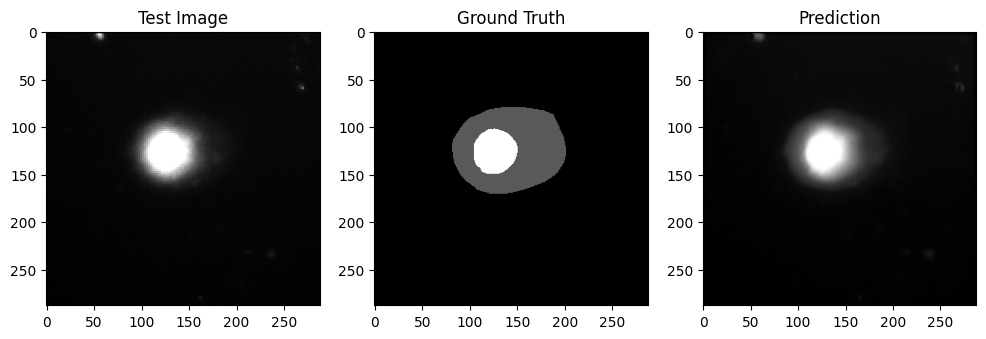

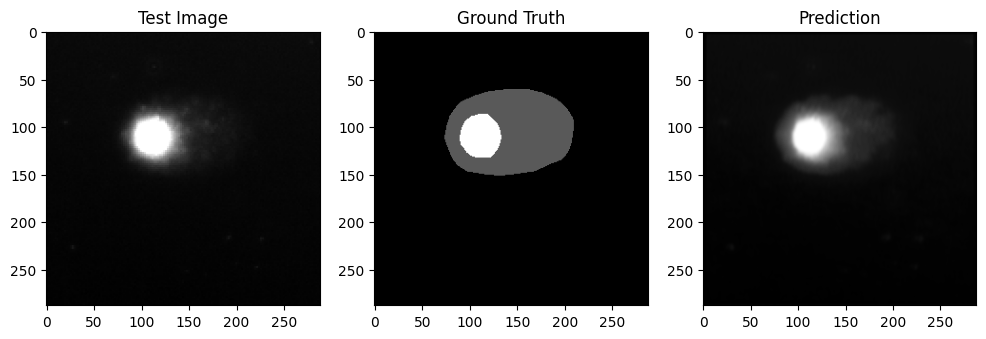

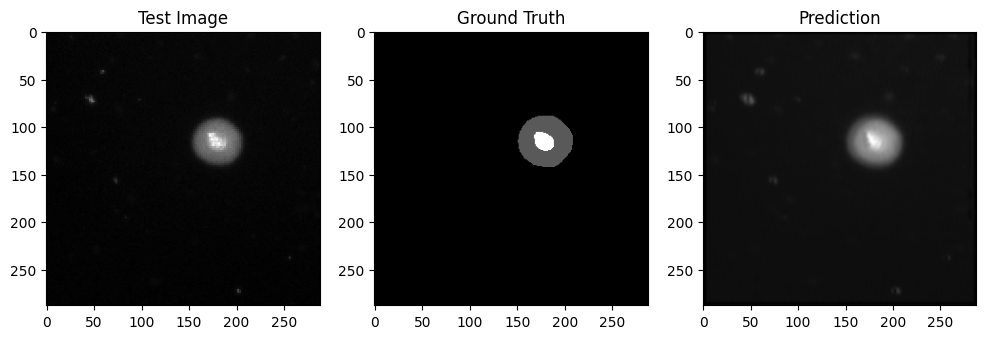

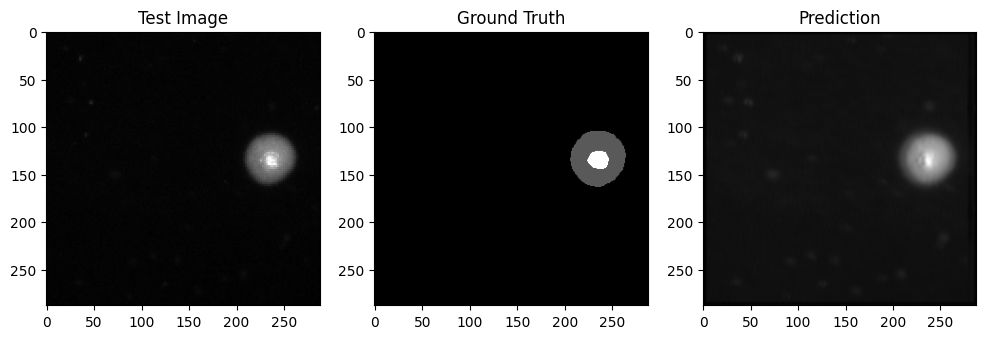

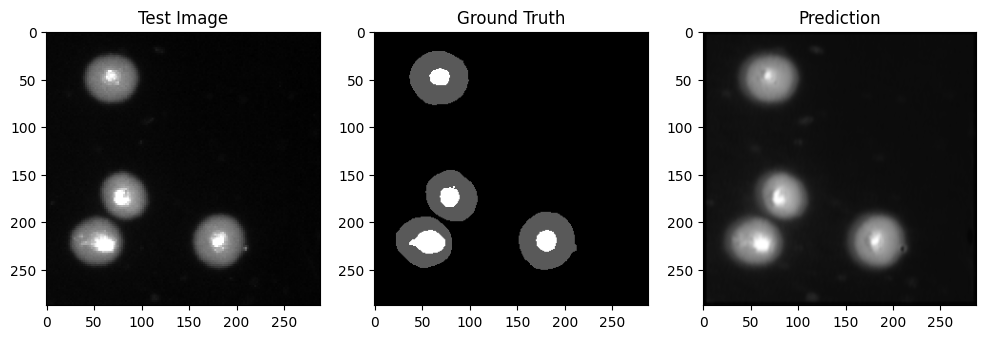

In [11]:
# 11. Display results on test data
def display_results(test_images, test_labels, model):
    predictions = model.predict(test_images)
    for i in range(5):  # Display 5 examples
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Test Image")
        plt.imshow(test_images[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(test_labels[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')

        plt.show()

display_results(test_images, test_labels, model)

In [12]:
# 12. Function to pad images 
def pad_image(image, target_size):
    pad_h = (target_size[0] - image.shape[0]) // 2
    pad_w = (target_size[1] - image.shape[1]) // 2
    
    padded_image = np.pad(image, ((pad_h, target_size[0] - image.shape[0] - pad_h),
                                  (pad_w, target_size[1] - image.shape[1] - pad_w),
                                  (0, 0)), mode='constant', constant_values=0)
    return padded_image


In [13]:
# 13.Function to display predictions on final test images
def display_final_results(final_test_images, final_test_labels, model, start, end):
    # Calculate the target size (next multiple of 16)
    target_size = ((1038 // 16 + 1) * 16, (1388 // 16 + 1) * 16)
    
    final_test_images_padded = np.array([pad_image(img, target_size) for img in final_test_images])
    final_predictions_padded = model.predict(final_test_images_padded[start:end])
    final_predictions = [pred[:1038, :1388, :] for pred in final_predictions_padded]
    x = 0

    for i in range(start, end):  
        plt.figure(figsize=(12, 4))
        print(i)

        plt.subplot(1, 3, 1)
        plt.title("Test Image")
        plt.imshow(final_test_images[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(final_test_labels[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(final_predictions[x].squeeze(), cmap='gray')
        x = x + 1
        
        plt.show()

E0000 00:00:1734322928.360533    7959 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734322928.463176    7959 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-16 07:22:13.050560: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=0,k3=0} for conv (f32[5,64,1040,1392]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,64,1040,1392]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a

1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step
0


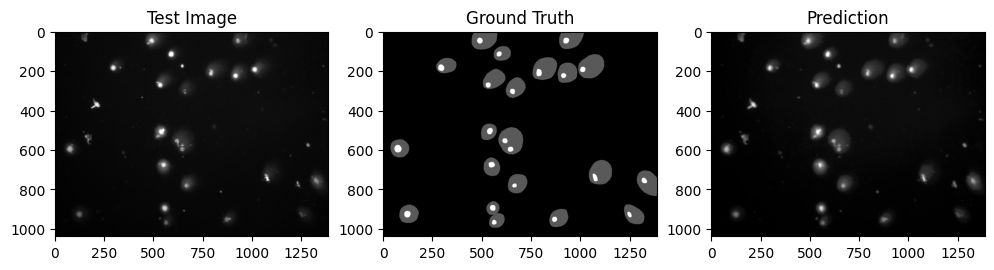

1


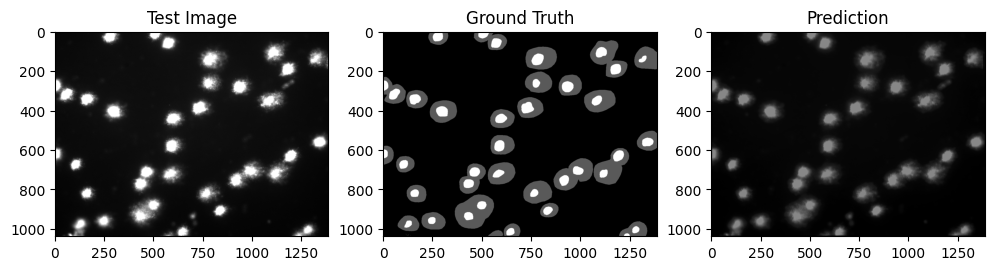

2


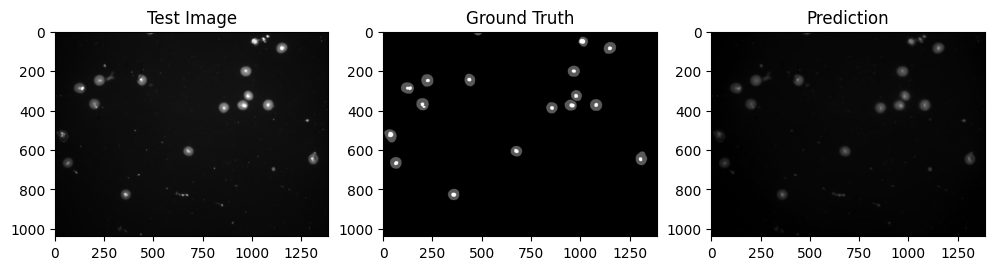

3


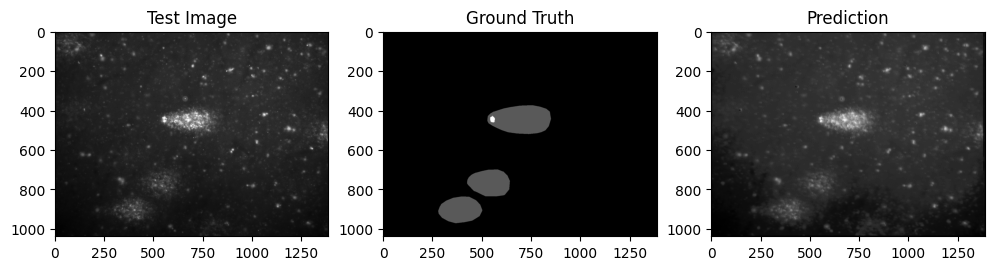

4


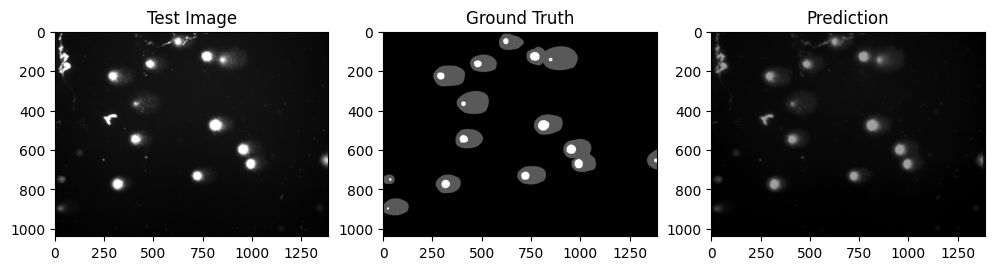

In [14]:
# 14. Display results
final_test_images, final_test_labels = load_images_and_labels(final_test_images_dir, final_test_labels_dir, image_size=(1038, 1388))
# Predict results for a subgroup of the final test images as per memory capacity
display_final_results(final_test_images, final_test_labels, model, 0, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5


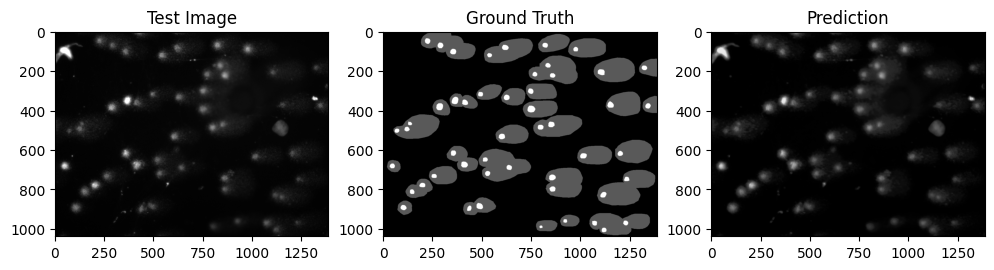

6


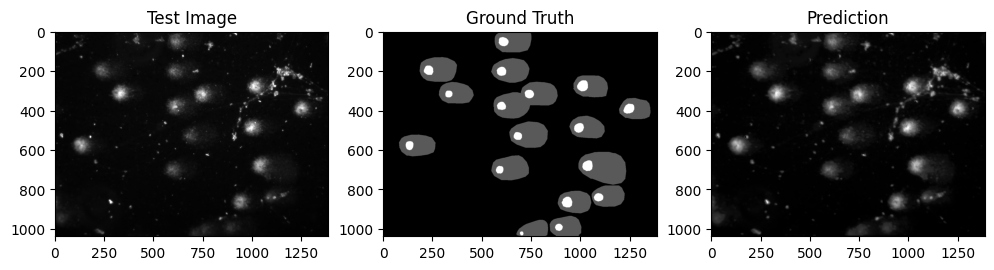

7


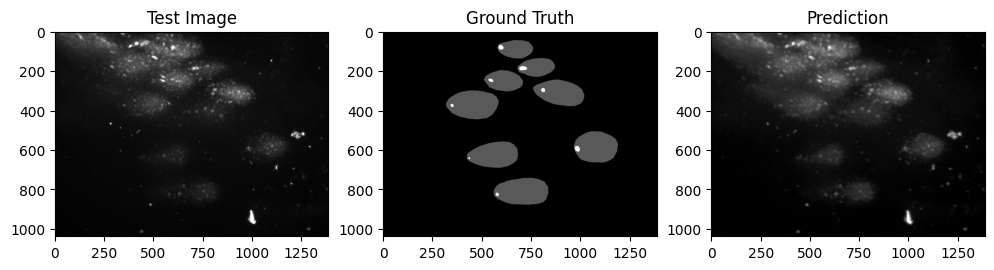

8


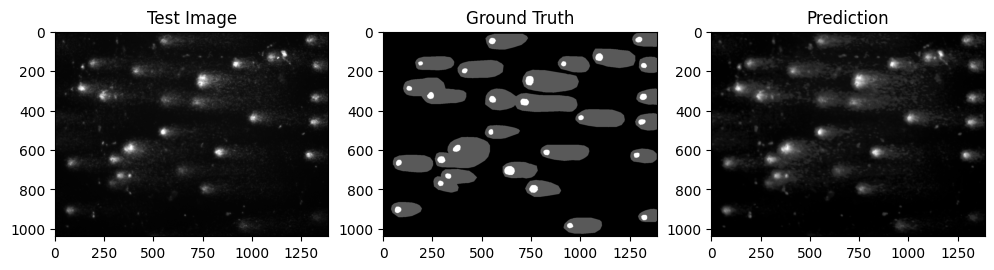

9


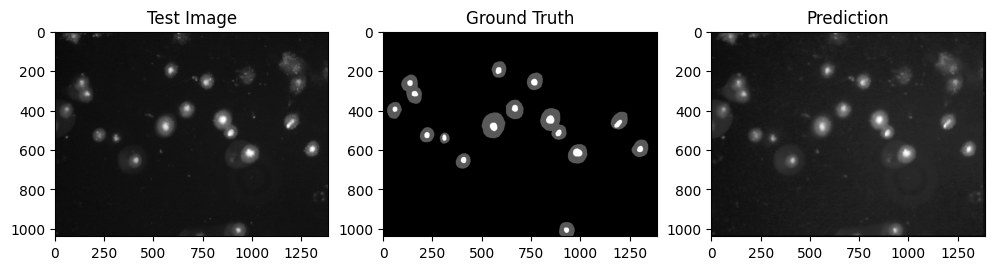

In [15]:
# Predict results for the remainder images
display_final_results(final_test_images, final_test_labels, model, 5, 10)